# Recommender System

This is a recommender system built with collaborative filtering for the movie lens dataset.

# Question 1

In [4]:
#Question 1
total_num_users = 671
total_num_ratings = 100004
total_num_movies = 9125

max_possible_ratings = total_num_users*total_num_movies

sparsity = total_num_ratings/max_possible_ratings

print(sparsity)

0.01633285017250883


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#Question 2
def load_data():
    data = pd.read_csv('ml-latest-small/ratings.csv', 
                       names= ['userid', 'movieid', 'rating', 'timestamp'],
                       header=0)
    
    #create R matrix: rows=users, columns=movies
    R = data.pivot_table(index=['userid'], columns=['movieid'], values='rating', fill_value=0).values
    return R, data
    
    
    

In [7]:
R,data = load_data()

In [81]:
values, counts = np.unique(R, return_counts=True)
dict(zip(values, counts))

mults = values*counts
avg_rating = np.sum(mults)/np.sum(counts[1:])
print(avg_rating)

3.54360825567


# Question 2

Shown below is a plot of the number of ratings for each rating value. In the plot below, the number of sparse (0 entries) is omitted since it dwarfs the other values by more than an order of magnitude. There are 5983282 sparse entries.

Our calculated average rating was 3.544, not including the sparse ratings (0 values). From the graph below, it's clear that this makes sense. Most of the ratings are 4 star, but the lower ratings in the range of 0.5-2.5 bring this average down.

100004


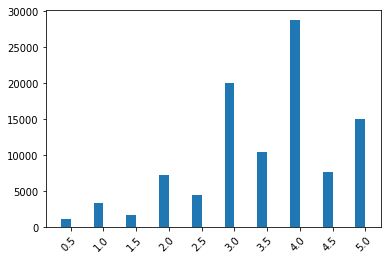

In [74]:
bins = values
ax = plt.subplot(111)
width = 0.3

index = np.arange(len(values[1:]))
ax.bar(index, counts[1:], width=width)

ax.set_xticks(index + width/2)
ax.set_xticklabels(values[1:],rotation=45, rotation_mode="anchor", ha="right")

plt.show()

The plot below includes the sparse entries. The second largest category is 4 stars, which has 28750 entries. This is barely visible on the graph.

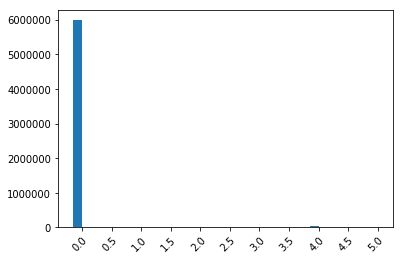

In [75]:
ax = plt.subplot(111)
width = 0.3

index = np.arange(len(values))
ax.bar(index, counts, width=width)

ax.set_xticks(index + width/2)
ax.set_xticklabels(values,rotation=45, rotation_mode="anchor", ha="right")

plt.show()

# Question 3
Plotting the distribution of movies. X-axis is the movie index in decreasing frequency and y-axis is the number of ratings the movie has.

In [109]:
#print(data)

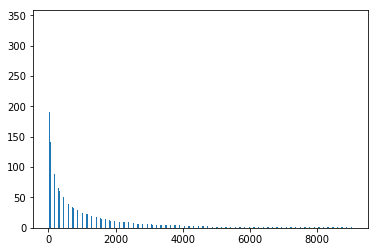

In [120]:
#print(R[:,0])
#print(R)

user_row, movie_col = R.shape
#print(user_row, movie_col)

distros = [np.count_nonzero(R[:,movie]) for movie in range(movie_col)]
#print(distros)

#decorate, sort, undecorate
movie_ids = np.arange(movie_col)
distros, movie_ids = zip(*sorted(zip(distros, movie_ids), reverse=True))

ax = plt.subplot(111)
width = 0.3

index = np.arange(len(movie_ids))
ax.bar(index, distros, width=width)

#ax.set_xticks(index + width/2)
#ax.set_xticklabels(movie_ids,rotation=45, rotation_mode="anchor", ha="right")

plt.show()
    

# Question 4
Plotting the distribution of users and their ratings in decreasing frequency. The X-axis is user index sorted by decreasing frequency and the y-axis is the number of movies that user has rated.

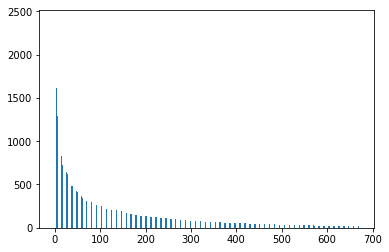

In [121]:
num_ratings_per_user = [np.count_nonzero(R[user,:]) for user in range(user_row)]
user_ids = np.arange(user_row)
num_ratings_per_user, user_ids = zip(*sorted(zip(num_ratings_per_user, user_ids), reverse=True))

ax = plt.subplot(111)
width = 0.3

index = np.arange(len(user_ids))
ax.bar(index, num_ratings_per_user, width=width)

#ax.set_xticks(index + width/2)
#ax.set_xticklabels(user_ids,rotation=45, rotation_mode="anchor", ha="right")

plt.show()

# Question 5
Explanation of the salient features of the distribution found in question 3 and implications for recommendation process.

Some movies are much more heavily reviewed than others. Since a user cannot review the same movie twice, we can assume that in the case where a movie has 671 reviews and there are 671 users, each user has reviewed the movie. Therefore, if we know our population size, the number of reviews that a movie has makes it a good indicator of population-wide preference. With collaborative filtering, we want to use commonalities in order to perform interpolation and fill in gaps. Since there is a lot of sparsity in this data, one reduction technique could be to remove movies that fall below a certain threshold of number of reviews. Movies with fewer reviews will cover less of the population spread and be less effective indicators of preference in the collaborative algorithm.

Concretely, question 3's plot shows that one movie had nearly 200 reviews, which spans approximately 29% of the population. Other movies had nearly 150 reviews, or nearly 22% of the population. Thus, these two movies would be excellent choices if we were required to only choose two members of the dataset.

# Question 6
Compute the variance of rating values received by each movie. 

# TODO DON'T FORGET TO DO THIS

# Question 7
By summing over $r_{uk}$, we sum up all of the user's ratings. The denominator is the length of the set containing indices for the user's specified ratings. 

\begin{equation}
\frac{\Sigma_{i\in I_{u}} r_{uk}}{|I_{u}|} \forall u \in {1....m}
\end{equation}

# Question 8
$I_{u} \cap I_{v}$ represents the intersection of the two sets of indices for users u and v. Concretely, this intersection is the set containing the indices of items both users rated. It's possible for the intersection to be the empty set $\emptyset$ if two users have not rated any of the same movies. 

For example, let's say two users rate one movie each. User 1 rates Batman and User 2 rates Star Wars. The intersection of indices would be the empty  set ($I_{u} \cap I_{v} = \emptyset$).

# Question 9
We perform mean centering as a form of normalization. Without normalization, the approach would be to define a match/peer group as the set consisting of the k-nearest neighbors given highest Pearson correlation coefficient. However, since we're iterating over items that don't necessarily have the same number of ratings per user, there will be differences from iteration to iteration. If we return the weighted average of the ratings as the predicted rating for an item, an especially sparsely rated value (one rated by a single user) can be skewed if the user is biased. For example, a user may rate every movie with 5 stars. Conversly, a user may rate every movie with 0.5 stars. A biased user such as this would skew a sparse row of ratings and offset the prediction. Mean subtraction is performed in order to minimize the skew these types of users can have on predictions.

# Question 10
Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k ( number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


In [24]:
from surprise import KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise.model_selection import cross_validate

data = Dataset.load_builtin('ml-100k')
ks = np.linspace(2, 100, num=50)
sim_options = {'name': 'pearson_baseline'}



In [27]:
%%capture
#run the sweeps
outputs = []
for k in ks:
    algo = KNNWithMeans(k=int(k), sim_options=sim_options)
    outputs.append(cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10))
    

In [28]:
avg_rmses = []
avg_maes = []
for output in outputs:
    #average the test_rmse
    avg_rmses.append(np.mean(output['test_rmse']))
    
    #average the test_mae
    avg_maes.append(np.mean(output['test_mae']))

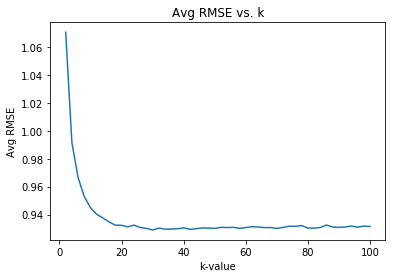

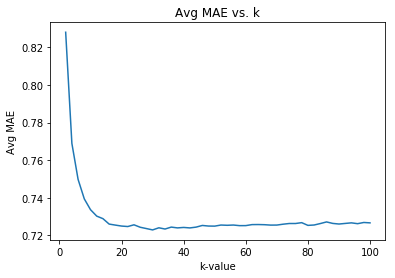

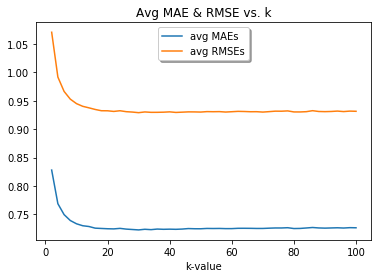

In [41]:
ax = plt.subplot(111)
width = 2

plt.title("Avg RMSE vs. k")
plt.ylabel("Avg RMSE")
plt.xlabel("k-value")
ax.plot(ks, avg_rmses)


plt.show()

ax = plt.subplot(111)
width = 2

plt.title("Avg MAE vs. k")
plt.ylabel("Avg MAE")
plt.xlabel("k-value")
ax.plot(ks, avg_maes)


plt.show()

ax = plt.subplot(111)
width = 2

plt.title("Avg MAE & RMSE vs. k")

plt.xlabel("k-value")
ax.plot(ks, avg_maes, label="avg MAEs")
ax.plot(ks, avg_rmses, label="avg RMSEs")
legend = ax.legend(loc='upper center', shadow=True)


plt.show()

# Question 11: Find a "Minimum k"
Goal is to find the point at which increasing k does not result in a signficant decrease in average RMSE or average MAE.

In [96]:
import math

def euclidean_elbow(ks, curve, verbose=False):
    #get first point
    s_x, s_y = ks[0], curve[0]

    #get last point
    e_x, e_y = ks[len(ks)-1], curve[len(curve)-1]

   

    slope = (e_y-s_y)/float(e_x-s_x)
    b = s_y - slope*s_x
#    print(s_x, s_y)
#    print(e_x, e_y)
#    print(slope)
    #get midpoint
    m_idx = int((len(ks)/2)-1)
    x_mid = ks[m_idx]
    y_mid = slope*x_mid + b


    #iterate through all points along the curve
    distances = []
    for x, y in zip(ks, curve):
        #get the x and y points of the vector line
        y2 = e_y
        y1 = s_y
        x2 = e_x
        x1 = s_x
        x3 = x
        y3 = y
        
        k = ((y2-y1) * (x3-x1) - (x2-x1) * (y3-y1)) / ((y2-y1)**2 + (x2-x1)**2)
        x4 = x3 - k * (y2-y1)
        y4 = y3 + k * (x2-x1) 
        #calculate distance
        distance = math.sqrt((x-x4)**2 + (y-y4)**2)
        distances.append(distance)

    #find max distance
    max_dist_index = np.argmax(distances)
    if(verbose):
        print(distances)
        print("best k: ", ks[max_dist_index])




    return max_dist_index

In [100]:
mae_idx = euclidean_elbow(ks, avg_maes)
print("Best k for MAE is index: ", mae_idx, "  || best k-value: ", ks[mae_idx])

rmse_idx = euclidean_elbow(ks, avg_rmses)
print("Best k for RMSE is index: ", rmse_idx, " || best k-value: ", ks[rmse_idx])



Best k for MAE is index:  7   || best k-value:  16.0
Best k for RMSE is index:  5  || best k-value:  12.0


# Question 12: Popular Movie Trimming
In this trimming, we trim the test set to contain movies that has received more than 2 ratings. To be specific, if a movie in the test set has received less than or equal to 2 ratings in the entire dataset then we delete that movie from the test set and do not predict the rating of that movie using the trained filter.